In [1]:
"""  Lorem Ipsum Doller """

'  Lorem Ipsum Doller '

In [2]:
import backtrader as bt
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import mplfinance as mpf
import matplotlib.patches as mpatches


# -----------------------------
# 1. Load Data
# -----------------------------
dta = pd.read_parquet("sampleSignal.parquet")
dta.index = pd.to_datetime(dta.index)
dta_bt = dta.reset_index().rename(columns={'index': 'datetime'})
dta_bt = dta_bt[['datetime','open','high','low','close','volume','RSI_14_crossed_up_EMA_15','SL','TP']]


In [3]:
signal_times = dta[dta['RSI_14_crossed_up_EMA_15'] == 1].index.to_list()

In [6]:
from bktst import EnterpriseTradingFramework


framework = EnterpriseTradingFramework()

# Example usage (commented)
results = framework.run_backtest(dta)



2025-09-28 07:45:56 | INFO | Enterprise Trading Framework initialized
2025-09-28 07:45:57 | INFO | Starting backtest with $100,000 capital
2025-09-28 07:45:58 | INFO | Initializing Enterprise Strategy
2025-09-28 07:45:58 | INFO | Strategy initialized - Starting Capital: $100,000.00
2025-09-28 07:45:59 | INFO | Order placed - Signal #1, Size: 3, Entry: 2636.347
2025-09-28 07:45:59 | INFO | Order executed - BUY 3 @ 2636.347
2025-09-28 07:45:59 | INFO | Order executed - SELL -3 @ 2634.969
2025-09-28 07:45:59 | INFO | Trade #1 closed - LOSS, P&L: $-4.13
2025-09-28 07:45:59 | INFO | Order placed - Signal #2, Size: 3, Entry: 2635.026
2025-09-28 07:45:59 | INFO | Order executed - BUY 3 @ 2635.026
2025-09-28 07:45:59 | INFO | Order executed - SELL -3 @ 2636.003
2025-09-28 07:45:59 | INFO | Trade #2 closed - WIN, P&L: $2.93
2025-09-28 07:45:59 | INFO | Order placed - Signal #3, Size: 3, Entry: 2636.292
2025-09-28 07:45:59 | INFO | Order executed - BUY 3 @ 2636.292
2025-09-28 07:45:59 | INFO | O

{'orders_table':     order_id            datetime  type  size     price     status  \
 0          1 2024-10-01 00:30:00   BUY     3  2636.347  SUBMITTED   
 1          2 2024-10-01 00:30:00  SELL    -3  2634.969  SUBMITTED   
 2          3 2024-10-01 00:30:00  SELL    -3  2637.774  SUBMITTED   
 3          4 2024-10-01 00:30:00   BUY     3  2636.347   ACCEPTED   
 4          5 2024-10-01 00:30:00  SELL    -3  2634.969   ACCEPTED   
 ..       ...                 ...   ...   ...       ...        ...   
 65        66 2024-10-01 03:17:00  SELL    -3  2636.732  SUBMITTED   
 66        67 2024-10-01 03:17:00   BUY     3  2635.714   ACCEPTED   
 67        68 2024-10-01 03:17:00  SELL    -3  2634.796   ACCEPTED   
 68        69 2024-10-01 03:17:00  SELL    -3  2636.732   ACCEPTED   
 69        70 2024-10-01 03:17:00   BUY     3  2635.714  COMPLETED   
 
     executed_price  executed_size  commission  
 0              NaN            NaN         NaN  
 1              NaN            NaN         N

In [10]:
trades = results['trades_table']

#dict_keys(['orders_table', 'trades_table', 'account_summary', 'daily_summary', 'analyzers', 'strategy'])

In [11]:
row_numbers = dta.index.get_indexer(trades['datetime_entry'])

# Entry/Exit prices
entry_array = trades['entry_price'].to_numpy()
exit_array = trades['exit_price'].to_numpy()

# SL/TP prices
sl_array = trades['sl_level'].to_numpy()  # assuming trades also has SL
tp_array = trades['tp_level'].to_numpy()  # assuming trades also has TP

# Structured arrays
entry_exit_arr = np.zeros(len(trades), dtype=[('row', int), ('entry', float), ('exit', float)])
entry_exit_arr['row'] = row_numbers
entry_exit_arr['entry'] = entry_array
entry_exit_arr['exit'] = exit_array

sltp_arr = np.zeros(len(trades), dtype=[('row', int), ('SL', float), ('TP', float)])
sltp_arr['row'] = row_numbers
sltp_arr['SL'] = sl_array
sltp_arr['TP'] = tp_array

In [ ]:
from ChartterX5 import Chartter

# Initialize chartter with wider and less tall proportions, no volume
chartter = Chartter(config={
    'chart_type': 'candle',
    'style': 'charles',
    'figratio': (20, 8),  # Adjusted for wider and less tall chart
    'volume': False  # Disable volume bars
})

# --- TradingView Market Colors ---
tv_mc = mpf.make_marketcolors(
    up='#26a69a',         # TradingView teal green for up candles
    down='#ef5350',       # TradingView red for down candles
    edge='inherit',       # Clean edges matching candle color
    wick='inherit',       # Wicks match candle colors
)

# --- TradingView Dark Theme ---
tradingview_dark = mpf.make_mpf_style(
    base_mpf_style='nightclouds',  # Start with dark base
    marketcolors=tv_mc,

    # TradingView dark theme colors
    figcolor='#131722',           # Dark navy background
    facecolor='#1e222d',          # Dark gray chart area
    gridcolor='#363a45',          # Dark gray grid
    gridstyle='-',                # Solid grid lines

    y_on_right=True,              # Price axis on right

    rc={
        # TradingView typography
        # 'font.family': ['-apple-system', 'BlinkMacSystemFont', 'Trebuchet MS', 'Roboto', 'Ubuntu', 'sans-serif'],
        'axes.labelsize': 10,
        'axes.titlesize': 14,
        'xtick.labelsize': 9,
        'ytick.labelsize': 7,         # Reduced size for price tick labels
        'legend.fontsize': 9,

        # Clean spacing with reduced left padding and full-width chart
        'axes.labelpad': 10,
        'xtick.major.pad': 6,
        'ytick.major.pad': 6,
        'axes.xmargin': 0,            # Remove left/right margins
        'axes.ymargin': 0,            # Remove top/bottom margins
        'figure.subplot.left': 0.05,  # Minimize left subplot padding
        'figure.subplot.right': 0.95, # Maximize right subplot to fit price scale

        # TradingView-style lines
        'lines.linewidth': 1.5,
        'lines.antialiased': True,

        # Clean borders and colors
        'axes.edgecolor': '#434651',  # Darker edge for dark theme
        'axes.linewidth': 1,
        'xtick.color': '#787b86',     # Light gray for x-axis ticks
        'ytick.color': '#787b86',     # Light gray for y-axis ticks
        'axes.labelcolor': 'none',    # Hide axis label color (labels are empty)

        # Grid styling
        'axes.grid': True,
        'axes.axisbelow': True,
        'grid.alpha': 0.6,            # Slightly more transparent for dark theme
        'grid.linewidth': 0.8,

        # Clean spines (show right spine for price scale)
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.top': False,
        'axes.spines.right': True,    # Show right spine for price scale
        'ytick.right': True,          # Show right y-axis ticks
    }
)


2025-09-27 13:18:56 | INFO | Generating chart 49933157-bd0f-4b62-8549-9b1cbc6d4e48 with 200 data points
2025-09-27 13:19:01 | INFO | Chart 49933157-bd0f-4b62-8549-9b1cbc6d4e48 generated successfully in 4.20s


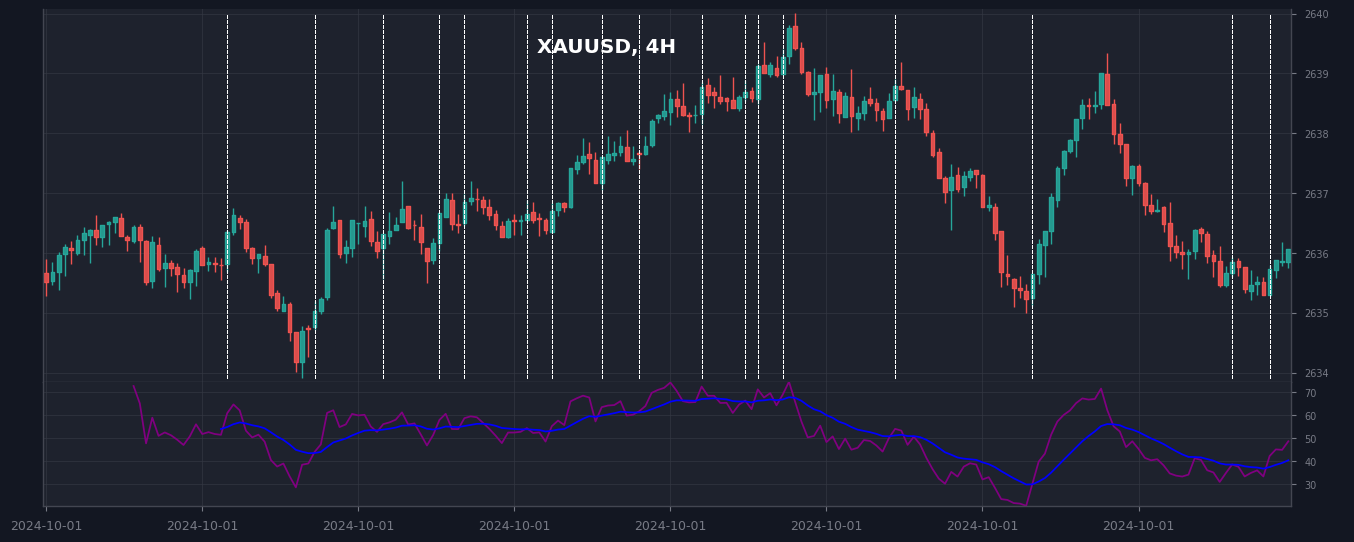

In [ ]:
dpart = dta

tradingview_config_4H = {
    'title': 'XAUUSD, 4H',                # TradingView style title
    'style': tradingview_dark,             # Use dark theme
    'type': 'candle',
    'volume': False,                      # Disable volume bars
    'show_nontrading': False,             # Ensure no extra y-axis spacing
    'datetime_format': '%Y-%m-%d',        # Format x-axis to show date only
    'xlabel': '',                         # Remove x-axis label
    'ylabel': '',                         # Remove y-axis label
    'xrotation': 0                        # Horizontal date labels
}

fig, axes = chartter.plot(
    dpart,
    addplot = [
        mpf.make_addplot(dpart['RSI_14'], panel=1, color='purple', ylabel='RSI'),
        mpf.make_addplot(dpart['EMA_15'], panel=1, color='blue', ylabel='ema15'),
    ],
    config=tradingview_config_4H,
    vlines=dict(
        vlines=signal_times,
        colors='white',
        linewidths=0.7,
        linestyle="--"
    ),
    returnfig=True
)

In [ ]:
# Access structured tables
orders = results['orders_table']
trades = results['trades_table']
account = results['account_summary']
daily = results['daily_summary']

orders

# trades

# account

,order_id,datetime,type,size,price,status,executed_price,executed_size,commission
0,1,2024-10-01 00:30:00,BUY,3,2636.347,SUBMITTED,NaN,NaN,NaN
1,2,2024-10-01 00:30:00,SELL,-3,2634.969,SUBMITTED,NaN,NaN,NaN
2,3,2024-10-01 00:30:00,SELL,-3,2637.774,SUBMITTED,NaN,NaN,NaN
3,4,2024-10-01 00:30:00,BUY,3,2636.347,ACCEPTED,NaN,NaN,NaN
4,5,2024-10-01 00:30:00,SELL,-3,2634.969,ACCEPTED,NaN,NaN,NaN


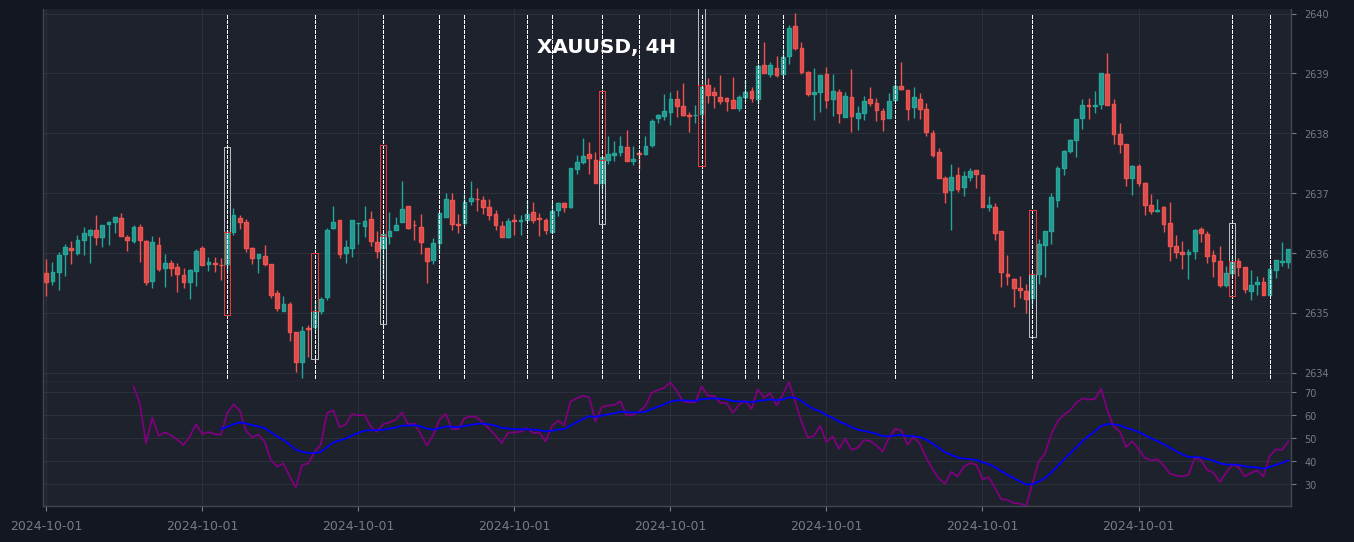

In [ ]:
import matplotlib.patches as mpatches

def draw_boxes_border_only(ax, arr, y1_col, y2_col, edge_color='red', lw=1.5, alpha=1.0):
    for row_data in arr:
        row = row_data['row']
        y1 = row_data[y1_col]
        y2 = row_data[y2_col]
        rect = mpatches.Rectangle(
            (row - 0.5, y1),  # left bottom corner
            1,                # width = 1 candle
            y2 - y1,          # height
            facecolor='none', # no fill
            edgecolor=edge_color,
            linewidth=lw,
            alpha=alpha,
            zorder=10         # Ensure it's drawn on top
        )
        ax.add_patch(rect)

# Draw SL/TP boxes with border only
draw_boxes_border_only(axes[0], sltp_arr, 'SL', 'TP', edge_color='white', lw=0.5)

# Draw Entry/Exit boxes with border only
draw_boxes_border_only(axes[0], entry_exit_arr, 'entry', 'exit', edge_color='red', lw=0.5)


fig